Text-based DistillBert Classification:
Uses distilbert-base-uncased

Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, DistilBertForSequenceClassification
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Tokenizer+Model

In [2]:

MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModel.from_pretrained(MODEL_NAME)

base_model = base_model.to(device)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Data Extraction

In [3]:
import os
import re
import numpy as np

def read_text_files_with_labels(path):
    texts = []
    labels = []

    class_folders = sorted([
    f for f in os.listdir(path)
    if os.path.isdir(os.path.join(path, f)) and not f.startswith(".")
]) #Avoids hidden files being picked up

    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)

        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)

            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)

                if os.path.isfile(file_path):
                    # Remove extension
                    file_name_no_ext, _ = os.path.splitext(file_name)

                    # Replace "_" with space
                    text = file_name_no_ext.replace('_', ' ')

                    # Remove digits
                    text_without_digits = re.sub(r'\d+', '', text)

                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    return np.array(texts), np.array(labels)


Data Collection

In [4]:
DATA_ROOT = "dataset"

train_texts, train_labels = read_text_files_with_labels(os.path.join(DATA_ROOT, "train"))
val_texts, val_labels = read_text_files_with_labels(os.path.join(DATA_ROOT, "val"))
test_texts, test_labels = read_text_files_with_labels(os.path.join(DATA_ROOT, "test"))

print("Train samples:", len(train_texts))
print("Val samples:", len(val_texts))
print("Test samples:", len(test_texts))

Train samples: 200
Val samples: 205
Test samples: 161


Text Dataset

In [5]:
MAX_LEN = 500

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

Data-Loaders

In [6]:

BATCH_SIZE = 16 #Roughly 50 per class in this setup

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset   = TextDataset(val_texts, val_labels, tokenizer)
test_dataset  = TextDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Classification Head

In [7]:

class TextClassifier(nn.Module):
    def __init__(self, num_classes, base_model):
        super().__init__()
        self.base_model = base_model
        hidden_size = base_model.config.hidden_size
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        # Mean pooling
        last_hidden = outputs.last_hidden_state  # (batch, seq_len, hidden_size)
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
        sum_embeddings = torch.sum(last_hidden * mask_expanded, dim=1)
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        pooled = sum_embeddings / sum_mask  # (batch, hidden_size)
        return self.fc(pooled)

Model Instantiation

In [8]:
model = TextClassifier(num_classes=4, base_model=base_model).to(device)

Optimizer + Loss

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Training Loop

In [10]:
EPOCHS = 10

train_losses = []
val_losses = []
misclassified_files = []

for epoch in range(EPOCHS):

    # Training

    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation

    model.eval()
    val_loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            file_names = batch.get("file_name", [None]*labels.size(0))  # fallback if not present

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss_total / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)

    # Logging

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Acc:  {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")
    print("-" * 40)

Epoch 1/10
Train Loss: 1.3870
Train Acc:  0.2400
Val Loss:   1.3527
Val Acc:    0.3415
----------------------------------------
Epoch 2/10
Train Loss: 1.3094
Train Acc:  0.5800
Val Loss:   1.3041
Val Acc:    0.5756
----------------------------------------
Epoch 3/10
Train Loss: 1.2332
Train Acc:  0.6150
Val Loss:   1.1952
Val Acc:    0.6098
----------------------------------------
Epoch 4/10
Train Loss: 1.0488
Train Acc:  0.7100
Val Loss:   1.0220
Val Acc:    0.7366
----------------------------------------
Epoch 5/10
Train Loss: 0.8417
Train Acc:  0.7850
Val Loss:   0.8532
Val Acc:    0.7659
----------------------------------------
Epoch 6/10
Train Loss: 0.6410
Train Acc:  0.8650
Val Loss:   0.7430
Val Acc:    0.7805
----------------------------------------
Epoch 7/10
Train Loss: 0.4896
Train Acc:  0.9000
Val Loss:   0.6455
Val Acc:    0.7951
----------------------------------------
Epoch 8/10
Train Loss: 0.3805
Train Acc:  0.9100
Val Loss:   0.5895
Val Acc:    0.7902
-----------------

Testing Block

In [16]:
# --- Testing Block ---

# Reconstruct class names in the same order used during loading
test_path = os.path.join(DATA_ROOT, "test")
class_names = sorted([
    f for f in os.listdir(test_path)
    if os.path.isdir(os.path.join(test_path, f)) and not f.startswith(".")
])

model.eval()
all_preds = []
misclassified_texts = []

global_idx = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.argmax(dim=1)

        batch_size = labels.size(0)

        for i in range(batch_size):
            pred_label = preds[i].item()
            true_label = labels[i].item()

            all_preds.append(pred_label)

            if pred_label != true_label:
                misclassified_texts.append(
                    f"Text: {test_texts[global_idx]} | "
                    f"True: {class_names[true_label]} ({true_label}) | "
                    f"Pred: {class_names[pred_label]} ({pred_label})"
                )

            global_idx += 1


# Compute accuracy
accuracy = (np.array(all_preds) == test_labels).mean()
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Number of misclassified samples: {len(misclassified_texts)}")


# --- Save misclassified filenames to file ---
with open("misclassified_text_files.txt", "w") as f:
    for item in misclassified_texts:
        f.write(item + "\n")

print("Detailed misclassified samples saved to misclassified_text_files.txt")



Test Accuracy: 70.19%
Number of misclassified samples: 48
Detailed misclassified samples saved to misclassified_text_files.txt


Loss Chart

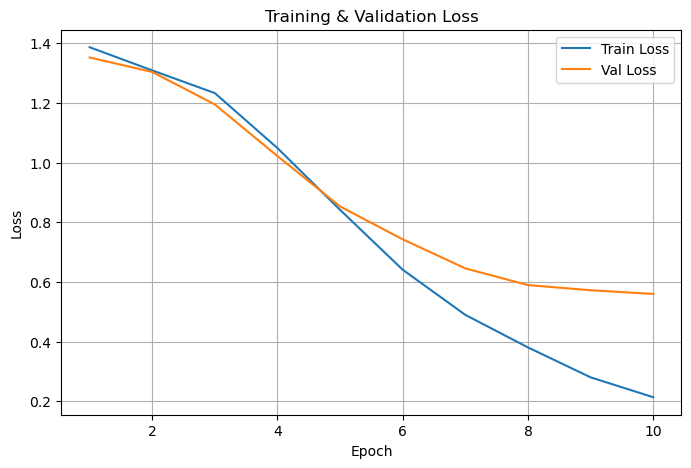

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("ls chart part2")
plt.show()

Saving Model

In [13]:
torch.save(model.state_dict(), "clean_text_classifier.pth")

Extracting Embeddings

In [14]:
def extract_final_text_embeddings(text_list, model_path, tokenizer, base_model):
    """
    text_list : list of strings
    model_path: path to your trained classifier
    tokenizer  : the tokenizer used for DistilBERT
    base_model : the underlying DistilBERT model (without the classifier head)
    """
    # Load the trained classifier
    trained_model = TextClassifier(num_classes=4, base_model=base_model).to(device)
    trained_model.load_state_dict(torch.load(model_path))
    trained_model.eval()

    all_embeddings = []

    with torch.no_grad():
        for text in text_list:
            # Tokenize
            encoding = tokenizer(
                text,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=128
            ).to(device)

            # Pass through the base model only
            outputs = trained_model.base_model(
                input_ids=encoding["input_ids"],
                attention_mask=encoding["attention_mask"]
            )

            # DistilBERT returns last_hidden_state (batch, seq_len, hidden_size)
            # Use [CLS]-like token embedding (first token) or mean pooling
            token_embeddings = outputs.last_hidden_state  # (1, seq_len, hidden_size)
            attention_mask = encoding["attention_mask"]

            # Mean pooling
            mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * mask_expanded, dim=1)
            sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
            embedding = sum_embeddings / sum_mask  # (1, hidden_size)

            all_embeddings.append(embedding.squeeze(0).cpu().numpy())

    return np.array(all_embeddings)
